In [1]:
from tinyai import *

In [2]:
from torcheval.metrics import MulticlassAccuracy

In [3]:
from datasets import load_dataset

dsd = load_dataset("daloopa/fashion-mnist-interview")

x,y = 'image','label'

bs = 256
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs, num_workers=4)

In [4]:
import matplotlib as mpl

def toggle_mpl():
    if mpl.rcParams['image.cmap'] == 'viridis':
        mpl.rcParams['image.cmap'] = 'gray_r'
    else:
        mpl.rcParams['image.cmap'] = 'viridis'
    print("setting cmap:", mpl.rcParams['image.cmap'])

toggle_mpl()

setting cmap: gray_r


In [10]:
from functools import partial
from torch import nn
from torch import optim


def get_model():
    act = partial(GeneralReLU, leak=0.1, sub=0.4)
    norm = nn.BatchNorm2d

    # 14, 7, 4, 2, 1
    hdims = (16, 32, 64, 128, 256)

    layers: list[nn.Module] = [conv(1, hdims[0], ks=5, act=act, norm=norm)]  # 14x14
    for fi, fo in zip(hdims, hdims[1:]):
        layers.append(ResBlock(fi, fo, stride=2, act=act, norm=norm))
    layers.append(
        nn.Sequential(GlobalAvgPool(), nn.Linear(hdims[-1], 10), nn.BatchNorm1d(10))
    )
    return nn.Sequential(*layers)


def get_learner():
    set_seed(42)
    model = get_model().apply(partial(init_weights, leaky=0.1))
    return Trainer(model, dls, loss_func=cross_entropy, lr=3e-3, opt_func=optim.AdamW)

In [6]:
learn = get_learner()
learn.summary()

Tot params: 1224958; MFLOPS: 3.5


/Users/tom/fun/tinyai/tinyai/nn/functional.py:9: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1694493834224/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  target = F.one_hot(target).to(torch.int32).float()


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(256, 1, 28, 28)|(256, 16, 14, 14)|448|0.1|
|ResBlock|(256, 16, 14, 14)|(256, 32, 7, 7)|14560|0.7|
|ResBlock|(256, 32, 7, 7)|(256, 64, 4, 4)|57792|0.9|
|ResBlock|(256, 64, 4, 4)|(256, 128, 2, 2)|230272|0.9|
|ResBlock|(256, 128, 2, 2)|(256, 256, 1, 1)|919296|0.9|
|Sequential|(256, 256, 1, 1)|(256, 10)|2590|0.0|


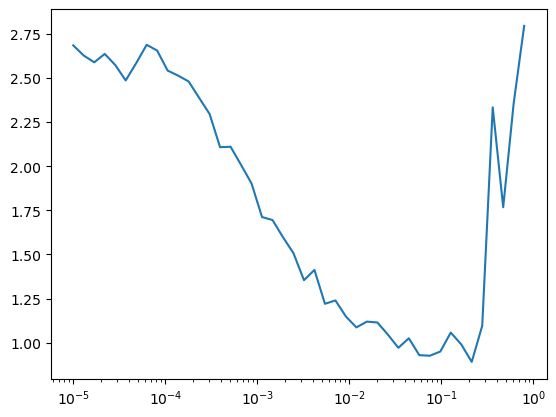

In [11]:
# learn.lr_find()

{'MulticlassAccuracy': <torcheval.metrics.classification.accuracy.MulticlassAccuracy object at 0x17c989ed0>}


epoch,train,loss,MulticlassAccuracy
0,train,0.5983,0.8094
0,eval,0.6694,0.7791
1,train,0.3421,0.8768
1,eval,0.4257,0.8378
2,train,0.2500,0.9089
2,eval,0.2513,0.9069


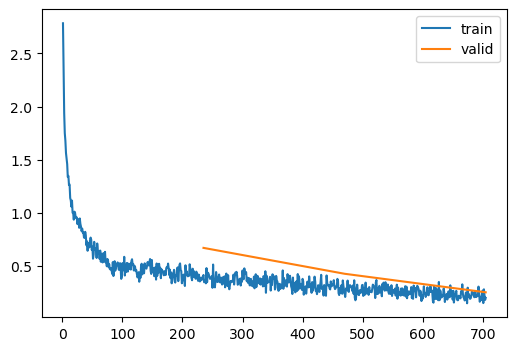

In [7]:
learn.fit_one_cycle(3, max_lr=8e-2, metrics={"accuracy": MulticlassAccuracy()})

(1.0, 0.04999999999999999)

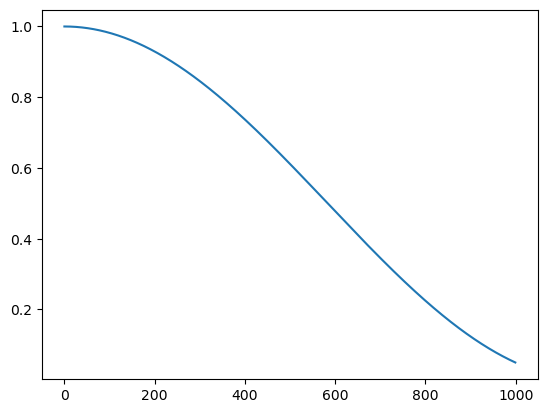

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import math

eta_min = 0.05
m = [(math.cos(x)+1)/2 for x in np.linspace(0, math.acos(eta_min*2 - 1), 1000)]
plt.plot(m)
max(m), min(m)

In [49]:
import math
import numpy as np


class CosineScheduler:
    def __init__(self, optimizer, T_max, eta_min=0.0):
        self.optimizer = optimizer
        self.default_lr = self.optimizer.defaults["lr"]
        if eta_min > self.default_lr:
            raise ValueError("minimum eta must not be greater than default lr")
        self.lr_mult = [
            (math.cos(x) + 1) / 2
            for x in np.linspace(0, math.acos(2 * eta_min / self.default_lr - 1), T_max)
        ]
        self.cur_epoch = 0

    def step(self):
        for pg in self.optimizer.param_groups:
            pg["lr"] = self.default_lr * self.lr_mult[self.cur_epoch]
        self.cur_epoch += 1


def _lr(learn):
    return learn.opt.param_groups[0]["lr"]

In [50]:
math.acos(2 * 3e-4 / 3e-3 - 1)

2.498091544796509

min = lr * mult

In [54]:
model = get_model()
opt = optim.AdamW(model.parameters())
sched = CosineScheduler(opt, T_max=len(dls.train), eta_min=5e-5)
sched.lr_mult[-10:]

[0.0749207596320206,
 0.0719218841976873,
 0.06897960320445745,
 0.06609430563915897,
 0.0632663729550762,
 0.060496179021518715,
 0.057784090074394834,
 0.055130464667791756,
 0.052535653626573586,
 0.04999999999999999]

epoch,train,loss
0,train,0.6454
0,eval,0.4482


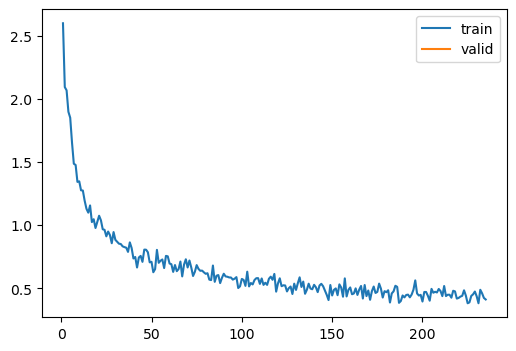

In [66]:
from functools import partial
from torch.optim import lr_scheduler

nepochs = 1
# sched = partial(lr_scheduler.CosineAnnealingLR, T_max=nepochs * len(dls.train), eta_min=1e-4)
sched = partial(CosineScheduler, T_max=nepochs * len(dls.train), eta_min=1e-4)
rec = RecorderCB(lr=_lr)

learn = get_learner()
learn.fit(1, cbs=[rec, BatchSchedCB(sched)])

Custom (eta 1e-4)
```
epoch	train	loss
0	train	0.6454
0	eval	0.4482
```

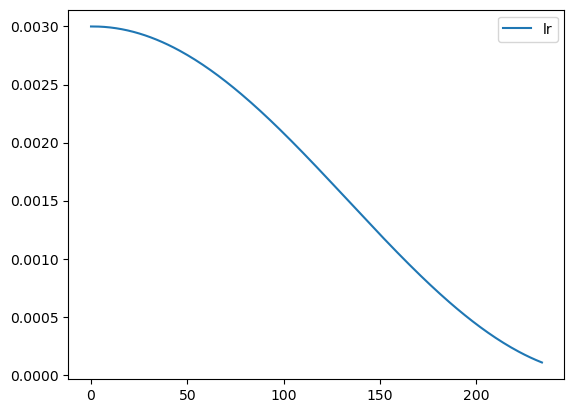

In [67]:
rec.plot()

Pytorch scheduler (eta 1e-4)
```
epoch	train	loss
0	train	0.6505
0	eval	0.4607
```

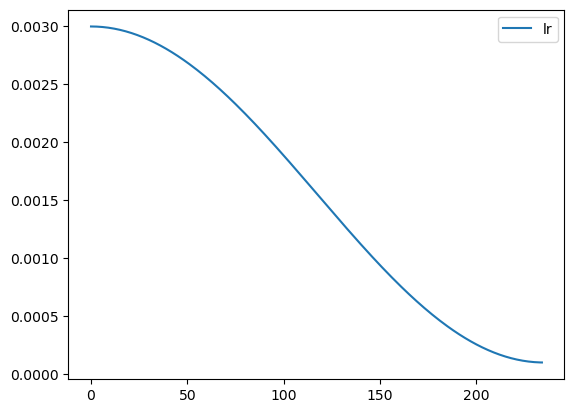

In [61]:
rec.plot()

In [73]:
from torch import tensor
import torch.nn.functional as F

F.mse_loss(tensor(custom_rec['lr']), tensor(pytorch_rec['lr']))

tensor(3.0822e-08)